## Completed

In [7]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations

# LOADING THE DATASET
import gdown

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Create a copy of the data
df = data.copy()


# Display the first few rows of the dataframe
print(data.head())

# Create a copy of the data
df = data.copy()

# Display column names
df.columns
df

Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 21.6MB/s]

   Year  Month  Day  Inflation
0  2000      1   31   0.329139
1  2000      2   28   1.940367
2  2000      3   31   4.469678
3  2000      4   30   3.672022
4  2000      5   31   2.382412


,Year,Month,Day,Inflation
0,2000,1,31,0.329139
1,2000,2,28,1.940367
2,2000,3,31,4.469678
3,2000,4,30,3.672022
4,2000,5,31,2.382412
...,...,...,...,...
298,2024,11,30,-2.068252
299,2024,12,31,-1.742696
300,2025,1,31,-4.035874
301,2025,2,28,-4.187438


In [8]:
df.columns
# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Display the first few rows to verify changes
print(df.head())

# Check the updated index
print(df.index)

            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
DatetimeIndex(['2000-01-31', '2000-02-28', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=303, freq=None)


In [9]:
df

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [10]:
! pip install optuna

In [11]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import optuna


import numpy as np
import pandas as pd
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# --- Load your dataset ---
# Make sure you already have 'df' loaded and 'Inflation' column exists

# Train-test split
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Use the target variable as inflation data (y)
y_train = train_data['Inflation']  # Replace with your actual column name if different
y_test = test_data['Inflation']

# Normalize the target using StandardScaler
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Prepare data for LSTM (create sequences)
def create_sequences(y_scaled, n_past, n_future):
    X, y_data = [], []
    for i in range(n_past, len(y_scaled) - n_future + 1):
        X.append(y_scaled[i - n_past:i, 0])
        y_data.append(y_scaled[i + n_future - 1:i + n_future, 0])
    return np.array(X), np.array(y_data)

# Objective function for Optuna
def objective(trial, y_train_scaled):
    n_past = trial.suggest_int("n_past", 1, 9)  # Time step size
    n_neurons = trial.suggest_int("n_neurons", 16, 128)
    n_layers = trial.suggest_int("n_layers", 1, 4)
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [1, 4, 8, 16, 32])
    optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])
    epochs = trial.suggest_int("epochs", 10, 100)

    # Create sequences
    X, y_seq = create_sequences(y_train_scaled, n_past, 1)

    # Reshape input to (samples, time_steps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    mse_scores = []

    # TimeSeriesSplit cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_seq[train_idx], y_seq[val_idx]

        # Build model
        model = Sequential()


        # First LSTM layer
        model.add(LSTM(n_neurons, return_sequences=(n_layers > 1), activation=activation,
                        input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))


        # Additional LSTM layers
        for i in range(1, n_layers):
            return_seq = (i < n_layers - 1)  # True for intermediate layers, False for last
            model.add(LSTM(n_neurons, return_sequences=return_seq, activation=activation))
            model.add(Dropout(dropout_rate))

        # Output layer
        model.add(Dense(1))

        # Compile model
        model.compile(optimizer=optimizer, loss="mean_squared_error")

        # Train model
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predict and evaluate
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

    return np.mean(mse_scores)

# Create and run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, y_train_scaled), n_trials=50)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)


[I 2025-05-29 09:54:06,651] A new study created in memory with name: no-name-c86daec1-f35e-4b47-8ad2-3a611137ddf5


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 965ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 931ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


[I 2025-05-29 09:58:18,395] Trial 0 finished with value: 0.32215819023033754 and parameters: {'n_past': 8, 'n_neurons': 112, 'n_layers': 4, 'activation': 'relu', 'dropout_rate': 0.45474542936763707, 'batch_size': 16, 'optimizer': 'adam', 'epochs': 99}. Best is trial 0 with value: 0.32215819023033754.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


[I 2025-05-29 09:58:42,587] Trial 1 finished with value: 0.22356093018865283 and parameters: {'n_past': 6, 'n_neurons': 110, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.3252056292964812, 'batch_size': 32, 'optimizer': 'adam', 'epochs': 16}. Best is trial 1 with value: 0.22356093018865283.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


[I 2025-05-29 09:59:09,677] Trial 2 finished with value: 0.07899361804893029 and parameters: {'n_past': 1, 'n_neurons': 101, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.1809919627314066, 'batch_size': 4, 'optimizer': 'adam', 'epochs': 13}. Best is trial 2 with value: 0.07899361804893029.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step


[I 2025-05-29 10:05:55,412] Trial 3 finished with value: 0.22237243616658162 and parameters: {'n_past': 6, 'n_neurons': 71, 'n_layers': 2, 'activation': 'sigmoid', 'dropout_rate': 0.4322381775302796, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 56}. Best is trial 2 with value: 0.07899361804893029.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step


[I 2025-05-29 10:06:50,014] Trial 4 finished with value: 0.6164463828839268 and parameters: {'n_past': 2, 'n_neurons': 126, 'n_layers': 2, 'activation': 'sigmoid', 'dropout_rate': 0.3486126549330917, 'batch_size': 32, 'optimizer': 'adam', 'epochs': 45}. Best is trial 2 with value: 0.07899361804893029.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 868ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


[I 2025-05-29 10:08:58,757] Trial 5 finished with value: 1.2071516608031259 and parameters: {'n_past': 3, 'n_neurons': 26, 'n_layers': 4, 'activation': 'relu', 'dropout_rate': 0.26208484872798443, 'batch_size': 8, 'optimizer': 'sgd', 'epochs': 88}. Best is trial 2 with value: 0.07899361804893029.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 477ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step


[I 2025-05-29 10:11:14,075] Trial 6 finished with value: 0.18383398199339523 and parameters: {'n_past': 8, 'n_neurons': 89, 'n_layers': 2, 'activation': 'tanh', 'dropout_rate': 0.4798636306001707, 'batch_size': 4, 'optimizer': 'adam', 'epochs': 34}. Best is trial 2 with value: 0.07899361804893029.


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 907ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 775ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 787ms/step


[I 2025-05-29 10:14:23,605] Trial 7 finished with value: 1.063213774198466 and parameters: {'n_past': 4, 'n_neurons': 35, 'n_layers': 4, 'activation': 'sigmoid', 'dropout_rate': 0.2892317888261755, 'batch_size': 1, 'optimizer': 'sgd', 'epochs': 26}. Best is trial 2 with value: 0.07899361804893029.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


[I 2025-05-29 10:16:06,070] Trial 8 finished with value: 0.12736285376397719 and parameters: {'n_past': 7, 'n_neurons': 126, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.3109526077552842, 'batch_size': 4, 'optimizer': 'adam', 'epochs': 48}. Best is trial 2 with value: 0.07899361804893029.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-05-29 10:17:22,736] Trial 9 finished with value: 0.0692582857226641 and parameters: {'n_past': 4, 'n_neurons': 102, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.13777935192312848, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 58}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 765ms/step


[I 2025-05-29 10:18:51,309] Trial 10 finished with value: 0.08441045751093067 and parameters: {'n_past': 4, 'n_neurons': 62, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.11355908703348667, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 71}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2025-05-29 10:20:05,672] Trial 11 finished with value: 0.09293619986236164 and parameters: {'n_past': 1, 'n_neurons': 92, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.11960461947260986, 'batch_size': 4, 'optimizer': 'rmsprop', 'epochs': 65}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


[I 2025-05-29 10:20:22,520] Trial 12 finished with value: 0.17671275911359874 and parameters: {'n_past': 2, 'n_neurons': 93, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.19228498714212083, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 11}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 847ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


[I 2025-05-29 10:22:02,421] Trial 13 finished with value: 0.1529915853148363 and parameters: {'n_past': 1, 'n_neurons': 55, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.19573541902061473, 'batch_size': 8, 'optimizer': 'rmsprop', 'epochs': 79}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step


[I 2025-05-29 10:22:42,566] Trial 14 finished with value: 0.3916678728645883 and parameters: {'n_past': 4, 'n_neurons': 105, 'n_layers': 2, 'activation': 'tanh', 'dropout_rate': 0.1816757365090989, 'batch_size': 16, 'optimizer': 'sgd', 'epochs': 38}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-05-29 10:24:06,142] Trial 15 finished with value: 0.09313853587009682 and parameters: {'n_past': 5, 'n_neurons': 80, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.23740392869444293, 'batch_size': 4, 'optimizer': 'adam', 'epochs': 59}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-05-29 10:24:37,243] Trial 16 finished with value: 0.1324748776172148 and parameters: {'n_past': 9, 'n_neurons': 102, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.1367653634736894, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 28}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


[I 2025-05-29 10:26:49,226] Trial 17 finished with value: 0.18036561128625406 and parameters: {'n_past': 2, 'n_neurons': 50, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.15993911999062918, 'batch_size': 4, 'optimizer': 'adam', 'epochs': 74}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 466ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 553ms/step


[I 2025-05-29 10:27:43,210] Trial 18 finished with value: 0.16405297391434032 and parameters: {'n_past': 3, 'n_neurons': 78, 'n_layers': 2, 'activation': 'tanh', 'dropout_rate': 0.22782976690157794, 'batch_size': 8, 'optimizer': 'rmsprop', 'epochs': 21}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


[I 2025-05-29 10:31:05,205] Trial 19 finished with value: 0.09925654611404625 and parameters: {'n_past': 5, 'n_neurons': 116, 'n_layers': 1, 'activation': 'sigmoid', 'dropout_rate': 0.10349435921682021, 'batch_size': 1, 'optimizer': 'sgd', 'epochs': 47}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step


[I 2025-05-29 10:31:59,343] Trial 20 finished with value: 0.16227747964912728 and parameters: {'n_past': 3, 'n_neurons': 98, 'n_layers': 2, 'activation': 'tanh', 'dropout_rate': 0.38318034296332126, 'batch_size': 32, 'optimizer': 'rmsprop', 'epochs': 40}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 816ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 818ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 816ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


[I 2025-05-29 10:33:53,647] Trial 21 finished with value: 0.08991514116566114 and parameters: {'n_past': 4, 'n_neurons': 62, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.14793205696335024, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 75}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


[I 2025-05-29 10:35:34,108] Trial 22 finished with value: 0.09275256043776649 and parameters: {'n_past': 5, 'n_neurons': 67, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.10107905140535002, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 65}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 808ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 817ms/step


[I 2025-05-29 10:37:05,293] Trial 23 finished with value: 0.17666427539113658 and parameters: {'n_past': 6, 'n_neurons': 43, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.1622017421420135, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 66}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 377ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step


[I 2025-05-29 10:38:22,761] Trial 24 finished with value: 0.10621743842488278 and parameters: {'n_past': 4, 'n_neurons': 84, 'n_layers': 2, 'activation': 'tanh', 'dropout_rate': 0.23240620851401372, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 84}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


[I 2025-05-29 10:40:20,546] Trial 25 finished with value: 0.15336471829877701 and parameters: {'n_past': 1, 'n_neurons': 57, 'n_layers': 3, 'activation': 'tanh', 'dropout_rate': 0.1353553085392203, 'batch_size': 4, 'optimizer': 'adam', 'epochs': 55}. Best is trial 9 with value: 0.0692582857226641.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


[I 2025-05-29 10:41:23,190] Trial 26 finished with value: 0.06302728173722238 and parameters: {'n_past': 3, 'n_neurons': 117, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.2003683499850776, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 90}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


[I 2025-05-29 10:42:23,369] Trial 27 finished with value: 0.07397507611590391 and parameters: {'n_past': 2, 'n_neurons': 121, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.213438257608378, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 99}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


[I 2025-05-29 10:43:28,665] Trial 28 finished with value: 0.06839875933654911 and parameters: {'n_past': 3, 'n_neurons': 121, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.2679964438624731, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 98}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


[I 2025-05-29 10:44:28,716] Trial 29 finished with value: 0.06484353440594845 and parameters: {'n_past': 3, 'n_neurons': 113, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.2815475548054889, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 91}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step


[I 2025-05-29 10:45:29,948] Trial 30 finished with value: 0.06427832845030412 and parameters: {'n_past': 3, 'n_neurons': 113, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.2768979197006082, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 91}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step


[I 2025-05-29 10:46:33,132] Trial 31 finished with value: 0.06409672156164575 and parameters: {'n_past': 3, 'n_neurons': 114, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.273653832955005, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 94}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


[I 2025-05-29 10:47:35,302] Trial 32 finished with value: 0.06571392251535169 and parameters: {'n_past': 3, 'n_neurons': 111, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.3451655862221866, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 92}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step


[I 2025-05-29 10:48:46,268] Trial 33 finished with value: 0.07619600184543243 and parameters: {'n_past': 2, 'n_neurons': 114, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.2796397176554631, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 93}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


[I 2025-05-29 10:49:54,168] Trial 34 finished with value: 0.07215014217893223 and parameters: {'n_past': 3, 'n_neurons': 108, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.25590718085604447, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 85}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


[I 2025-05-29 10:50:57,052] Trial 35 finished with value: 0.08889657862666259 and parameters: {'n_past': 2, 'n_neurons': 119, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.31715677978486273, 'batch_size': 32, 'optimizer': 'rmsprop', 'epochs': 93}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step


[I 2025-05-29 10:52:38,752] Trial 36 finished with value: 0.09131195278695806 and parameters: {'n_past': 3, 'n_neurons': 127, 'n_layers': 2, 'activation': 'relu', 'dropout_rate': 0.37560211320793563, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 82}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 466ms/step


[I 2025-05-29 10:58:37,817] Trial 37 finished with value: 0.1371192541216193 and parameters: {'n_past': 5, 'n_neurons': 110, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.33294065198649003, 'batch_size': 1, 'optimizer': 'sgd', 'epochs': 88}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 371ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step


[I 2025-05-29 11:00:26,773] Trial 38 finished with value: 0.0791287809251864 and parameters: {'n_past': 2, 'n_neurons': 96, 'n_layers': 2, 'activation': 'relu', 'dropout_rate': 0.2902170609995381, 'batch_size': 8, 'optimizer': 'rmsprop', 'epochs': 99}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


[I 2025-05-29 11:01:36,078] Trial 39 finished with value: 0.07202451309910177 and parameters: {'n_past': 3, 'n_neurons': 128, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.24891533241955158, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 89}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step


[I 2025-05-29 11:03:03,509] Trial 40 finished with value: 0.640667676904122 and parameters: {'n_past': 6, 'n_neurons': 115, 'n_layers': 2, 'activation': 'relu', 'dropout_rate': 0.40157934847603005, 'batch_size': 32, 'optimizer': 'sgd', 'epochs': 79}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


[I 2025-05-29 11:04:06,124] Trial 41 finished with value: 0.07075757547148888 and parameters: {'n_past': 3, 'n_neurons': 109, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.34545883944127753, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 93}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


[I 2025-05-29 11:05:07,895] Trial 42 finished with value: 0.0767567141380725 and parameters: {'n_past': 4, 'n_neurons': 120, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.30486248994890114, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 92}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


[I 2025-05-29 11:06:11,011] Trial 43 finished with value: 0.08052429069201457 and parameters: {'n_past': 3, 'n_neurons': 105, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.3447082818285764, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 96}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


[I 2025-05-29 11:07:01,836] Trial 44 finished with value: 0.15215400317725836 and parameters: {'n_past': 2, 'n_neurons': 112, 'n_layers': 1, 'activation': 'sigmoid', 'dropout_rate': 0.43486211578998935, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 87}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


[I 2025-05-29 11:07:52,039] Trial 45 finished with value: 0.1327598172090988 and parameters: {'n_past': 4, 'n_neurons': 21, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.36631880481072043, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 82}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


[I 2025-05-29 11:11:46,669] Trial 46 finished with value: 0.08353581777334954 and parameters: {'n_past': 1, 'n_neurons': 99, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.20966718630130507, 'batch_size': 1, 'optimizer': 'rmsprop', 'epochs': 90}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


[I 2025-05-29 11:12:47,224] Trial 47 finished with value: 0.06405025042702311 and parameters: {'n_past': 3, 'n_neurons': 90, 'n_layers': 1, 'activation': 'relu', 'dropout_rate': 0.2740235333097471, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 96}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 747ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 855ms/step


[I 2025-05-29 11:15:22,517] Trial 48 finished with value: 0.3968337860598126 and parameters: {'n_past': 4, 'n_neurons': 86, 'n_layers': 4, 'activation': 'sigmoid', 'dropout_rate': 0.2748611066715395, 'batch_size': 16, 'optimizer': 'adam', 'epochs': 96}. Best is trial 26 with value: 0.06302728173722238.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


[I 2025-05-29 11:16:42,748] Trial 49 finished with value: 0.08109828813082806 and parameters: {'n_past': 2, 'n_neurons': 90, 'n_layers': 2, 'activation': 'relu', 'dropout_rate': 0.2501222875864332, 'batch_size': 8, 'optimizer': 'rmsprop', 'epochs': 77}. Best is trial 26 with value: 0.06302728173722238.


Best Hyperparameters: {'n_past': 3, 'n_neurons': 117, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.2003683499850776, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 90}


Best Hyperparameters: {'n_past': 3, 'n_neurons': 117, 'n_layers': 1, 'activation': 'tanh', 'dropout_rate': 0.2003683499850776, 'batch_size': 16, 'optimizer': 'rmsprop', 'epochs': 90}
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
RMSE: 3.7252583833539172
MSE: 13.87755002274864
MAE: 2.2359638047369
MAPE: 44.74492836332883
R-squared: 0.9700815585216382


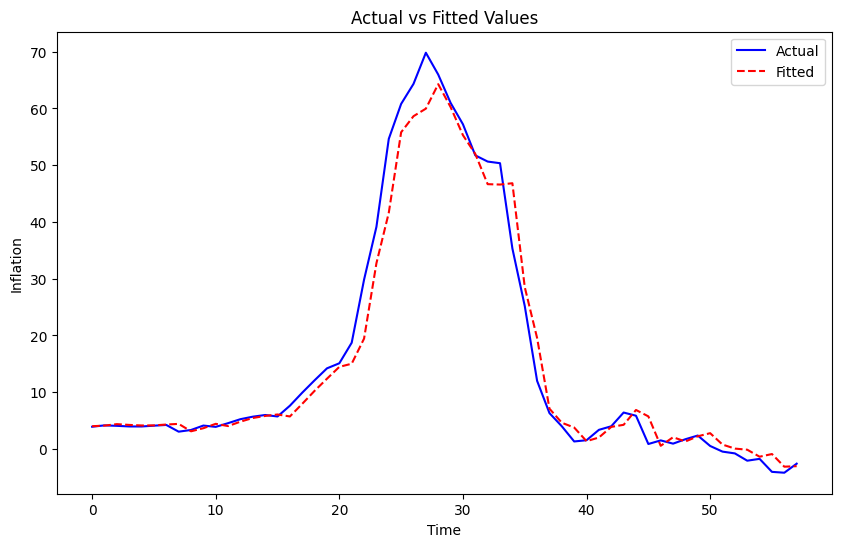

In [12]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import optuna

# Best hyperparameters found
print("Best Hyperparameters:", study.best_params)

# Using the best hyperparameters to train the model
best_params = study.best_params
n_past = best_params["n_past"]
n_neurons = best_params["n_neurons"]
n_layers = best_params["n_layers"]
activation = best_params["activation"]
dropout_rate = best_params["dropout_rate"]
batch_size = best_params["batch_size"]
optimizer = best_params["optimizer"]
epochs = best_params["epochs"]

# Create sequences with the chosen time step size (window size)
X_train, y_train = create_sequences(y_train_scaled, n_past, 1)
X_test, y_test = create_sequences(y_test_scaled, n_past, 1)

# Build the LSTM model with the best parameters
model = Sequential()

# First LSTM layer
model.add(LSTM(n_neurons, return_sequences=(n_layers > 1), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_rate))

# Additional LSTM layers
for _ in range(n_layers - 1):
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dropout(dropout_rate))

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer=optimizer, loss="mean_squared_error")

# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

# Predict on test set
y_pred_scaled = model.predict(X_test)

# Inverse transform to get the actual predicted values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate performance metrics
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, y_pred)

# Print the results
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R-squared: {r2}")

# Plot actual vs fitted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label="Actual", color='blue')
plt.plot(y_pred, label="Fitted", color='red', linestyle='--')
plt.title('Actual vs Fitted Values')
plt.xlabel('Time')
plt.ylabel('Inflation')
plt.legend()
plt.show()
